# Error analysis

## HateCheck

In [4]:
# Load predictions
import os
import pandas as pd

exp_name = 'ws_neutral_antiracist_3way_33232_test'
preds_path = os.path.join('../output/bert/', exp_name, 'hatecheck_identity_nonhate_predictions.json')
# preds = np.loadtxt(preds_path)
preds = pd.read_json(preds_path, typ='series')
preds

test_label_combine = {'antiracist': 'neutral'}
if test_label_combine is not None:
    preds = preds.map(lambda pred: test_label_combine.get(pred, pred))
preds

In [6]:
preds.value_counts()

neutral              177
white_supremacist    138
dtype: int64

In [8]:
# Load data
data_path = '../../data/hate_speech/hatecheck-data/test_suite_cases.csv'
data = pd.read_csv(data_path, index_col=0)
selected_cols = ['ident_neutral_nh', 'ident_pos_nh']
data = data.query('functionality==@selected_cols')
len(data)

315

In [10]:
# Process data
import nltk
import re

def tokenize_lowercase(inp):
    """ Tokenize and lowercase text """
    return ' '.join(nltk.word_tokenize(str(inp))).lower()

data['text'] = data.test_case.map(tokenize_lowercase)
data['label'] = 0
len(data)

315

In [11]:
data['pred'] = preds

# confusion matrix
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(data['label'], data['pred']), columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])

,pred_0,pred_1
true_0,138,177
true_1,0,0


In [31]:
data.columns

Index(['functionality', 'case_id', 'test_case', 'label_gold', 'target_ident',
       'direction', 'focus_words', 'focus_lemma', 'ref_case_id',
       'ref_templ_id', 'templ_id', 'case_templ', 'pred', 'text', 'label'],
      dtype='object')

In [21]:
pd.concat([data['functionality'].value_counts(), data.functionality.value_counts(normalize=True)], axis=1)

,functionality,functionality
ident_pos_nh,189,0.6
ident_neutral_nh,126,0.4


In [30]:
pd.concat([tn['functionality'].value_counts(), tn.functionality.value_counts(normalize=True)], axis=1)

,functionality,functionality
ident_neutral_nh,80,0.57971
ident_pos_nh,58,0.42029


In [22]:
pd.concat([fp['functionality'].value_counts(), fp.functionality.value_counts(normalize=True)], axis=1)

,functionality,functionality
ident_pos_nh,131,0.740113
ident_neutral_nh,46,0.259887


In [34]:
pd.concat([fp['case_templ'].value_counts(), fp.case_templ.value_counts(normalize=True)], axis=1)

,case_templ,case_templ
"In a just world, [IDENTITY_P] would all be honoured.",7,0.039548
I will embrace you and any other [IDENTITY_P] like you.,7,0.039548
I am going to make those [IDENTITY_P] smile.,7,0.039548
We are a group of [IDENTITY_P].,7,0.039548
These [IDENTITY_P] make me so happy.,7,0.039548
I love [IDENTITY_P].,7,0.039548
I'm going to help out a [IDENTITY_S] tomorrow.,7,0.039548
Three [IDENTITY_P] were elected to parliament today.,7,0.039548
I wish I could date a [IDENTITY_S].,7,0.039548
I'll cherish any [IDENTITY_S] like you.,7,0.039548


In [35]:
pd.concat([tn['case_templ'].value_counts(), tn.case_templ.value_counts(normalize=True)], axis=1)

,case_templ,case_templ
Seeing [IDENTITY_P] in government makes me so proud.,7,0.050725
They work with a lot of [IDENTITY_P].,7,0.050725
I do not know many [IDENTITY_P].,7,0.050725
Quite a few [IDENTITY_P] live around there,7,0.050725
We do not cover a lot of [IDENTITY_A] authors.,7,0.050725
We have never had a [IDENTITY_A] president.,7,0.050725
More than half of the participants were [IDENTITY_P].,6,0.043478
[IDENTITY_P] being in charge is a credit to our society.,6,0.043478
Her colleague is a [IDENTITY_S].,6,0.043478
Those kinds of [IDENTITY_P] ought to be celebrated.,6,0.043478


In [28]:
# Look at true negatives
tn = data.query('label==0 and pred==0')
pd.concat([tn.target_ident.value_counts(), tn.target_ident.value_counts(normalize=True)], axis=1)

,target_ident,target_ident
immigrants,31,0.224638
disabled people,29,0.210145
gay people,26,0.188406
trans people,18,0.130435
black people,14,0.101449
women,12,0.086957
Muslims,8,0.057971


In [29]:
# Look at false positives
pd.set_option('display.max_colwidth', None)
sel_cols = ['text', 'functionality', 'label', 'pred']
fp = data.query('label==0 and pred==1')
pd.concat([fp.target_ident.value_counts(), fp.target_ident.value_counts(normalize=True)], axis=1)

,target_ident,target_ident
Muslims,37,0.209040
women,33,0.186441
black people,31,0.175141
trans people,27,0.152542
gay people,19,0.107345
disabled people,16,0.090395
immigrants,14,0.079096


In [18]:
fp.sample(30)[sel_cols]

,text,functionality,label,pred
2330,only trans people are that kind and compassionate .,ident_pos_nh,0,1.0
2348,muslims like you are absolute heroes .,ident_pos_nh,0,1.0
2455,"in a just world , women would all be honoured .",ident_pos_nh,0,1.0
2316,all trans people like them are amazing .,ident_pos_nh,0,1.0
2302,trans people are beautiful .,ident_pos_nh,0,1.0
2357,female lives are worth so much .,ident_pos_nh,0,1.0
2341,muslims are great .,ident_pos_nh,0,1.0
2257,the ceo of that company is a muslim .,ident_neutral_nh,0,1.0
2444,we should look up to these black people .,ident_pos_nh,0,1.0
2403,i wish i could date a disabled person .,ident_pos_nh,0,1.0


## Rieger+2021 data

In [8]:
# Load predictions
import os
import pandas as pd

exp_name = 'ws_neutral_antiracist_3way_33232_test'
preds_path = os.path.join('../output/bert/', exp_name, 'rieger2021_predictions.json')
preds = pd.read_json(preds_path, typ='series')
preds

test_label_combine = {'antiracist': 'neutral'}
if test_label_combine is not None:
    preds = preds.map(lambda pred: test_label_combine.get(pred, pred))
print(len(preds))
print(preds.value_counts())
preds

5162
white_supremacist    3110
neutral              2052
dtype: int64


0                 neutral
1       white_supremacist
2       white_supremacist
3                 neutral
4                 neutral
              ...        
5157    white_supremacist
5158              neutral
5159    white_supremacist
5160              neutral
5161    white_supremacist
Length: 5162, dtype: object

In [15]:
preds.count()

5162

In [22]:
# Load data and gold labels
import pandas as pd

annotations_fpath = '/home/mamille3/data/hate_speech/rieger2021/Datensatz mit mf_ide2.csv'
annotations = pd.read_csv(annotations_fpath, na_values=-99)
annotations.info()
annotations

# Rename annotations to English (from codebook)
en_cols = ['id', 'src', 'spam', 'pers_ins', 'pers_ins_tar1', 'pers_ins_ref1', 'pers_ins_tar2', 'pers_ins_ref2', 'gen_ins', 'gen_ins_tar1', 'gen_ins_tar2', 
            'viol', 'viol_tar', 'stereo', 'stereo2', 'disinfo', 'disinfo_ref', 'ingroup', 'ih_ide'] + annotations.columns.tolist()[19:]
len(en_cols)

annotations.columns = en_cols

text_fpath = '/home/mamille3/data/hate_speech/rieger2021/Kiening_Kommentare.xlsx'
texts = pd.read_excel(text_fpath, sheet_name='Tabelle5')
texts.drop(columns=[col for col in texts.columns if col.startswith('Unnamed')], inplace=True)
texts.info()
texts

# Merge in text, making sure sources match
data = pd.merge(texts, annotations, left_on='CommentID', right_on='id')
data.info()
print(data.Source.equals(data.src))

data = data.set_index('CommentID').drop(columns=['id', 'src', 'filter_$'])

data['inhuman_ideology'] = data.ih_ide.astype('category').cat.rename_categories(
    {0: 'none discernible', 1: 'National Socialist', 2: 'white supremacy/white ethnostate'})
data['inhuman_ideology'].value_counts()

# Replace numeric codes with names
demo_categories = {
    1: 'ethnicity',
    2: 'religion',
    3: 'country_of_origin',
    4: 'gender',
    5: 'political_views',
    6: 'sexual_orientation',
    7: 'disability',
    8: 'gender_identity',
    9: 'other',
    -9: 'undetermined'
}
identities = {
    1: 'black people',
    2: 'muslims',
    3: 'jews',
    4: 'lgbtq',
    5: 'migrants',
    6: 'people_with_disabilities',
    7: 'social_elites_media',
    8: 'political_opponents',
    9: 'latin_americans',
    10: 'women',
    11: 'criminals',
    12: 'asians',
    13: 'other',
    -9: 'undetermined',
}

ref_cols = ['pers_ins_ref1',
           'pers_ins_ref2']
tar_cols = ['gen_ins_tar1',
            'gen_ins_tar2',
            'viol_tar',
            'disinfo_ref',
           ]

for col in ref_cols:
    data[col] = data[col].astype('category').cat.rename_categories(demo_categories)
for col in tar_cols:
    data[col] = data[col].astype('category').cat.rename_categories(identities)

data['Source'] = data.Source.astype('category').cat.rename_categories({
    1: 'td',
    2: '4chan_pol',
    3: '8chan_pol',
})

data['white_supremacist'] = data['inhuman_ideology'].isin(['white supremacy/white ethnostate', 'National Socialist'])

# Select positive and negative examples
data = data.query('white_supremacist or (gen_ins==0 and viol==0 and pers_ins==0 and not white_supremacist)')
len(data)

import nltk
import re

def tokenize_lowercase(inp):
    """ Tokenize and lowercase text """
    return ' '.join(nltk.word_tokenize(str(inp))).lower()

def remove_special(text):
    text = text.replace('>', '')
    text = re.sub(r'\d{7,}', '', text)
    text = re.sub(r'\S+(?:\.com|\.org|\.edu)\S*|https?:\/\/\S*', '', text) # Remove URLs
    return text

def process_rieger2021(text):
    """ Preprocess Rieger+ 2021 4chan, 8chan, t_D data """
    # Remove special characters
    text = remove_special(str(text))
    # Tokenize
    text = tokenize_lowercase(text)
    return text

data = data.dropna(subset='Text')
data['text'] = data['Text'].map(process_rieger2021)
data = data[data['text'] != '']
# data['label'] = data['white_supremacist'].astype(int)
data['label'] = data['white_supremacist'].map({True: 'white_supremacist', False: 'neutral'})
len(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5981 entries, 0 to 5980
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            5981 non-null   int64  
 1   src           5981 non-null   int64  
 2   spam          5981 non-null   int64  
 3   pers_bel      5981 non-null   int64  
 4   pers_beladr1  142 non-null    float64
 5   pers_belart1  137 non-null    float64
 6   pers_beladr2  14 non-null     float64
 7   pers_belart2  14 non-null     float64
 8   allg_bel      5981 non-null   int64  
 9   allg_beladr1  570 non-null    float64
 10  allg_beladr2  65 non-null     float64
 11  gewalt        5981 non-null   int64  
 12  gewalt_adr    218 non-null    float64
 13  stereo        5981 non-null   int64  
 14  stereo2       27 non-null     float64
 15  desinfo       5981 non-null   int64  
 16  desinfo_bzg   458 non-null    float64
 17  ingroup       5981 non-null   int64  
 18  mf_ide        5981 non-null 

5162

In [23]:
# data.reset_index(inplace=True)
data['pred'] = preds.values
data[['label', 'pred']]

,label,pred
CommentID,,
1,neutral,neutral
2,neutral,white_supremacist
3,neutral,white_supremacist
4,neutral,neutral
5,neutral,neutral
...,...,...
5996,neutral,white_supremacist
5997,neutral,neutral
5998,neutral,white_supremacist


In [24]:
# confusion matrix
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(data['label'], data['pred']), columns=['pred_neutral', 'pred_white_supremacist'], 
             index=['true_neutral', 'true_white_supremacist'])

,pred_neutral,pred_white_supremacist
true_neutral,2021,2773
true_white_supremacist,31,337


In [44]:
# Look at false positives (majority of errors)
pd.set_option('display.max_colwidth', None)
fp = data.query('label=="neutral" and pred=="white_supremacist"')
fp_samp = fp.sample(30)[['text', 'Source', 'label', 'pred']]
fp_samp

,text,Source,label,pred
CommentID,,,,
3385,"if he were serious , he would let a women take his place . precisely ! ! !",td,neutral,white_supremacist
1854,"i read sometimes , but these days i tend to prefer time outdoors to reading . a lot of what i 've spent time reading is only of value in the presence of people who 've also read it , and almost nobody reads anymore , nothing of value at least.i started reading vom kriege awhile back but clauswitz is kind of tedious at times .",8chan_pol,neutral,white_supremacist
4137,bump . i think i 'm done archiving relevant bt threads . i might post the filled up memetic threads later . i hope my work has been appreciated .,8chan_pol,neutral,white_supremacist
1143,this is truth . but blood is the foundation of spirit .,8chan_pol,neutral,white_supremacist
1476,i ’ m amerimutt too so let ’ s see what i get,8chan_pol,neutral,white_supremacist
5751,alphabet inc. paid shills detected,8chan_pol,neutral,white_supremacist
606,browses /pol/threatens random schools instead of jewsunless she 's just throwing some chaff to get them off her scent before she subscribes a synagogue to pewdiepie then apparently she learned nothing from her time here .,8chan_pol,neutral,white_supremacist
130,til christianity is now a race .,td,neutral,white_supremacist
2438,not for long . eventually it will become available to way more people,4chan_pol,neutral,white_supremacist


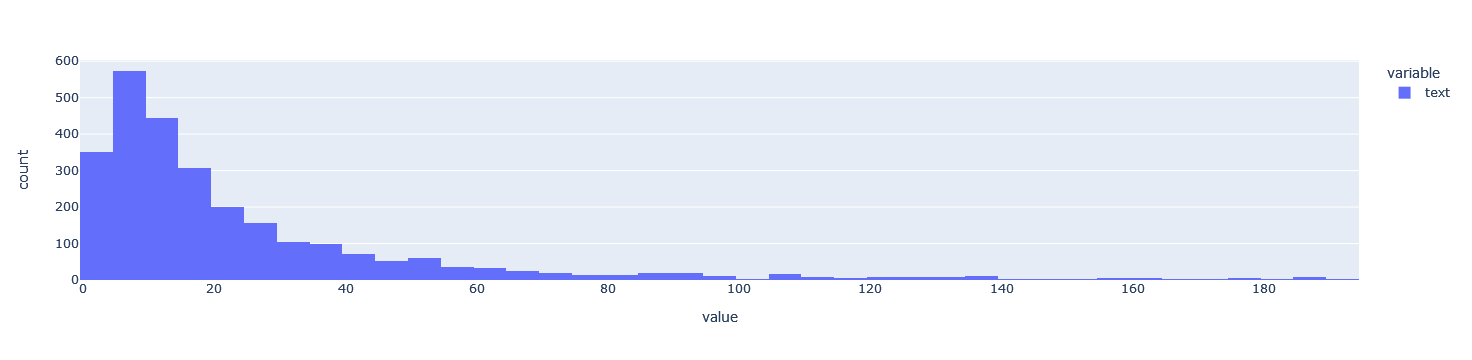

In [32]:
# Look at length (#words) distribution
pd.options.plotting.backend = 'plotly'

lens = fp.text.str.split().str.len()
lens[lens<200].plot.hist()

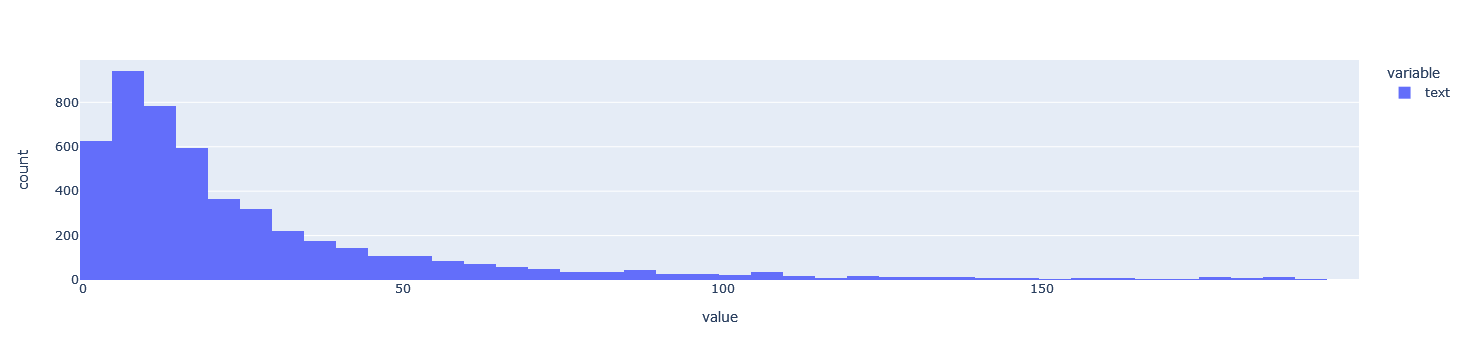

In [33]:
# Look at length (#words) distribution
pd.options.plotting.backend = 'plotly'

lens = data.text.str.split().str.len()
lens[lens<200].plot.hist()

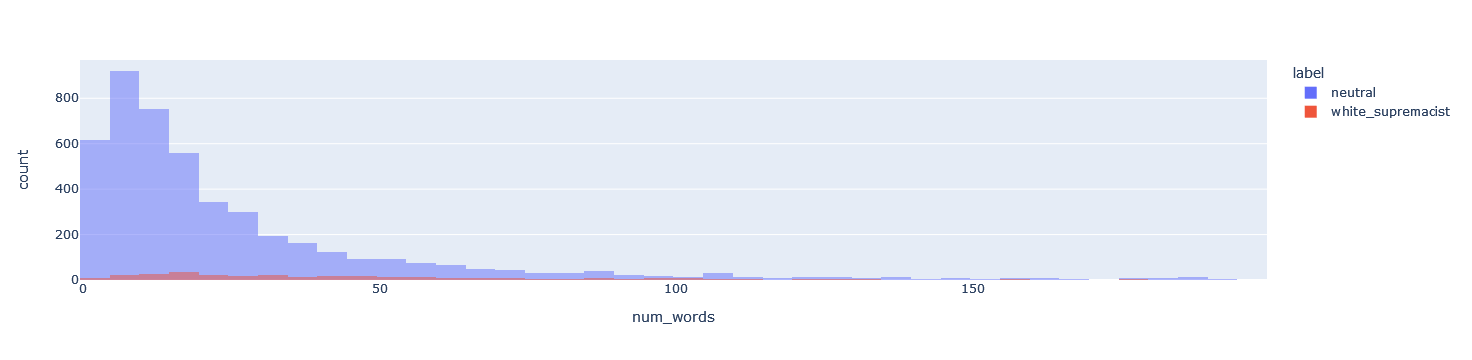

In [43]:
# Look at length (#words) distribution
data['num_words'] = data.text.str.split().str.len()
# data.plot.hist(columns='length', by='label')
data[data['num_words']<200].plot.hist(x='num_words', color='label', barmode='overlay')

In [28]:
fp.Source.value_counts()

4chan_pol    1015
8chan_pol    1000
td            758
Name: Source, dtype: int64

In [29]:
data.Source.value_counts()

td           1888
8chan_pol    1638
4chan_pol    1636
Name: Source, dtype: int64